<a href="https://colab.research.google.com/github/davidraamirez/GradientWithoutBackpropagation/blob/main/LogisticRegression_bwd_gradient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import the necessary packages**



In [1]:
import torch
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split

In [2]:
import torchvision

In [3]:
from torch import nn

In [4]:
import time 

In [5]:
import matplotlib.pyplot as plt

# **Loading and preprocessing the data**

In [6]:
#Load the dataset
penguins = tfds.load('penguins', as_supervised=True, split='train')

In [7]:
X, y = penguins.batch(500).get_single_element()
X, y = X.numpy(), y.numpy()

In [8]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, stratify=y)

In [9]:
Xtrain = torch.from_numpy(Xtrain).float()
Xtest = torch.from_numpy(Xtest).float()

In [10]:
ytrain = torch.from_numpy(ytrain).long()
ytest = torch.from_numpy(ytest).long()

# **Define Logistic Regression**

In [11]:
class SimpleLogisticRegression(nn.Module):
  def __init__(self, input_size, w, b):
    super().__init__()
    self.weight = nn.Parameter(w)
    self.bias = nn.Parameter(b)

  def forward(self, x):
    x = x.reshape(1, -1)
    return torch.softmax(x@self.weight + self.bias, 1)

In [12]:
# We check if CUDA is available.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


# **Initialize the parameters**

In [13]:
# We initialize the parameters randomly and the model with an input size
w = torch.randn((4, 3), requires_grad=True)
b = torch.randn((3, ), requires_grad=True)
LG = SimpleLogisticRegression(4, w, b).to(device)

In [14]:
# We try our model with the first example
print(LG(Xtrain[0].to(device)))

tensor([[0.2875, 0.1945, 0.5180]], grad_fn=<SoftmaxBackward0>)


Calculate predictions

In [15]:
def pred(x,w,b):
  ypred=torch.randn((x.shape[0],3))
  for j in range (x.shape[0]):
    xj = x[j].reshape(1, -1)
    ypred[j]=torch.softmax(xj@w+b,1)
  return ypred

In [16]:
ypred=pred(Xtrain,w,b)

# **Define accuracy**

In [17]:
def accuracy(ytrue, ypred):
  return (ypred.argmax(1) == ytrue).float().mean()

In [18]:
# Average accuracy at initialization is 33% (random guessing).
accuracy(ytrain.to(device),ypred.to(device))

tensor(0.1880)

# **Define cross entropy**

In [19]:
def cross_entropy(ytrue,ypred):
  return - ypred[torch.arange(0, ypred.shape[0]), ytrue].log().mean()

In [20]:
print(cross_entropy(ytrain.to(device),ypred.to(device)))

tensor(1.5727, grad_fn=<NegBackward0>)


# **Train and evaluate the network**

In [21]:
def train_bwd_gradient(x,y):

  x,y=x.to(device),y.to(device)

  losses = [] # Vector with the cross entropy values of test set
  accuracies = [] # Vector with the accuracy values of test set
  errors=[] # Vector with the number of misclassification of the test set

  l_rate0 = 0.2 # Learning rate used 

  # Initialize the parameters
  w = torch.randn((4, 3), requires_grad=True)
  b = torch.randn((3, ), requires_grad=True)

  w, b = w.to(device), b.to(device)

  ypred=pred(x,w,b)
  ypred = ypred.to(device)
  loss = cross_entropy(y,ypred) # Loss function

  # Calculate the start time 
  t=0
  it=0
  t0=time.time()
  print('Time', t, 'loss', loss)

  while (loss>0.3): 

    loss.backward()

    with torch.no_grad():
      
      # Apply gradients 
      w -= l_rate0*w.grad
      b -= l_rate0*b.grad

      # Gradients are accumulated: we need to zero them out before the next iteration.
      w.grad.zero_()
      b.grad.zero_()
    
    # We calculate the number of misclassification of the test set with the updated model and we add to the errors vector
    LG = SimpleLogisticRegression(4, w, b).to(device)
    ypredT = torch.randn(Xtest.size(0),3)
    error=0
    for i in range (Xtest.size(0)):
      ypredT[i]=LG(Xtest[i].to(device))
      if (LG(Xtest[i].to(device)).argmax(1)- ytest[i])!=0:
        error = error+ 1
    errors.append(error)
    ypredT = ypredT.to(device)

    ypred=pred(x,w,b)
    
    # We calculate the accuracy of the test set with the updated model and we add to the accuracy vector
    accuracies.append(accuracy(ytest,ypredT).item())

    # We calculate the cross_entropy of the test set with the updated model and we add to the accuracy vector
    loss = cross_entropy(y,ypred.to(device))
    lossT = cross_entropy(ytest,ypredT)
    losses.append(lossT.detach().item())

    #We add the execution time of the iteration
    t1=time.time()
    t+=t1-t0
    t0=t1
    it+=1
    print('Time', t, 'loss', loss)
    
  print('Final execution time', t)  
  print('Number of iterations', it)
  print('Mean execution time of an iteration', t/it)
  
  return w,b,errors,losses,accuracies


In [22]:
w, b,errors,losses,accuracies = train_bwd_gradient(Xtrain, ytrain)

Time 0 loss tensor(2.5856, grad_fn=<NegBackward0>)
Time 0.09977364540100098 loss tensor(2.4084, grad_fn=<NegBackward0>)
Time 0.17649340629577637 loss tensor(2.2399, grad_fn=<NegBackward0>)
Time 0.28862977027893066 loss tensor(2.0810, grad_fn=<NegBackward0>)
Time 0.3781599998474121 loss tensor(1.9326, grad_fn=<NegBackward0>)
Time 0.46698522567749023 loss tensor(1.7950, grad_fn=<NegBackward0>)
Time 0.6502439975738525 loss tensor(1.6683, grad_fn=<NegBackward0>)
Time 0.7762014865875244 loss tensor(1.5522, grad_fn=<NegBackward0>)
Time 0.8633406162261963 loss tensor(1.4460, grad_fn=<NegBackward0>)
Time 1.054478645324707 loss tensor(1.3491, grad_fn=<NegBackward0>)
Time 1.2501678466796875 loss tensor(1.2609, grad_fn=<NegBackward0>)
Time 1.576646089553833 loss tensor(1.1808, grad_fn=<NegBackward0>)
Time 1.872208833694458 loss tensor(1.1083, grad_fn=<NegBackward0>)
Time 2.038992166519165 loss tensor(1.0432, grad_fn=<NegBackward0>)
Time 2.2465462684631348 loss tensor(0.9851, grad_fn=<NegBackward0

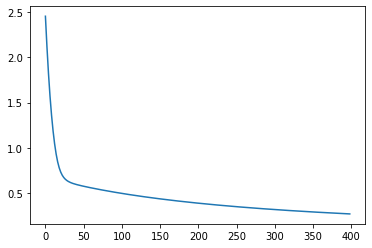

In [23]:
plt.plot(losses)

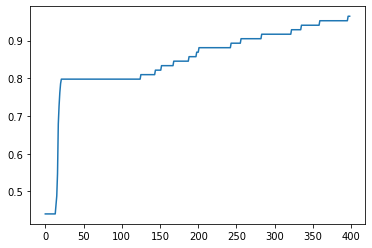

In [24]:
plt.plot(accuracies)

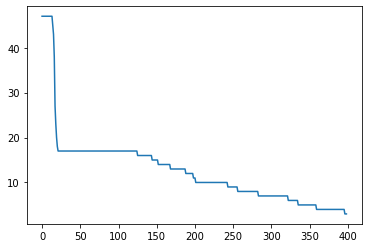

In [25]:
plt.plot(errors)